# **Rakuten France Classification des données des produits multimodaux**
<br>
<br>

## 1. Contexte

**Rakuten**, créé en 1997 au Japon et à l'origine du concept de **marketplace**, est devenu l'une des plus grandes plateformes de e-commerce au monde avec une communauté de plus de 1,3 milliard de membres.

**Rakuten Institute of Technology (RIT)** est le **département de recherche et d'innovation de Rakuten**. RIT fait de la recherche appliquée dans les domaines de la vision par ordinateur, du traitement du langage naturel, de l'apprentissage machine/profond et de l'interaction homme-machine. Le 6 janvier 2020, RIT propose le challenge suivant : **Rakuten France Multimodal Product Data Classification**.

Ce défi porte sur le thème de la classification multimodale (texte et image) des codes types de produits à grande échelle où l'objectif est de prédire le code type de chaque produit tel que défini dans le catalogue de Rakuten France.

Le catalogage des produits via la catégorisation des titres et des images est un problème fondamental pour tout marché de e-commerce, avec des applications allant de la recherche et des recommandations personnalisées à la compréhension des requêtes. Les approches manuelles basées sur des règles de catégorisation ne sont pas évolutives puisque les produits commerciaux sont organisés en plusieurs classes. Le déploiement d'approches multimodales serait une technique utile pour les entreprises de e-commerce car elles ont du mal à catégoriser les produits en fonction des images et des labels des marchands et à éviter les doublons, en particulier lors de la vente de produits neufs et d'occasion de marchands professionnels et non professionnels.

Les progrès dans ce domaine de recherche ont été limités par le manque de données réelles provenant de catalogues commerciaux réels. Ce projet présente plusieurs aspects de recherche intéressants en raison de la nature intrinsèquement bruyante des labels et des images des produits, de la taille des catalogues de e-commerce et de la distribution déséquilibrée typique des données.


### 1.1. Description du problème
L'objectif de ce défi des données est la **classification à grande échelle des données produit multimodales (texte et image) en codes de type de produit**.

Par exemple, dans le catalogue Rakuten France, un produit avec une désignation ou un titre français "Klarstein Présentoir 2 Montres Optique Fibre" associé à une image et parfois à une description complémentaire. Ce produit est classé sous le code de type de produit 1500 . Il existe d'autres produits avec des titres, des images et des descriptions possibles différents, qui se trouvent sous le même code de type de produit. Compte tenu de ces informations sur les produits, comme l'exemple ci-dessus, ce défi propose de modéliser un classificateur pour classer les produits dans son code de type de produit correspondant.

### 1.2. Description des données
Pour ce challenge, Rakuten France met à disposition env. **99 000 listes de produits au format CSV**, y compris le **train (84 916)** et l'ensemble de **test (13 812)**. L'ensemble de données se compose de désignations de produits, de descriptions de produits, d'images de produits et de leur code de type de produit correspondant.  

Les données sont réparties selon deux critères, formant quatre ensembles distincts : entraînement ou test, entrée ou sortie.

- X_train.csv : fichier d'entrée d'entraînement
- Y_train.csv : fichier de sortie d'entraînement
- X_test.csv : fichier d'entrée de test

De plus, le fichier images.zip est fourni contenant toutes les images. La décompression de ce fichier fournira un dossier nommé images avec deux sous-dossiers nommés image_train et image_test, contenant respectivement des images d'entraînement et de test.
  
  

# 2. Import des données

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import chi2_contingency
import os
import statsmodels.api
import PIL
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re
from googletrans import Translator
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Fenzhengrou\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Fenzhengrou\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('../data/X_train_update.csv')
df = df.rename(columns={ df.columns[0]: "ID" })
df.head()

ID                                        designation  \
0   0  Olivia: Personalisiertes Notizbuch / 150 Seite...   
1   1  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   
2   2  Grand Stylet Ergonomique Bleu Gamepad Nintendo...   
3   3  Peluche Donald - Europe - Disneyland 2000 (Mar...   
4   4                               La Guerre Des Tuques   

                                         description   productid     imageid  
0                                                NaN  3804725264  1263597046  
1                                                NaN   436067568  1008141237  
2  PILOT STYLE Touch Pen de marque Speedlink est ...   201115110   938777978  
3                                                NaN    50418756   457047496  
4  Luc a des id&eacute;es de grandeur. Il veut or...   278535884  1077757786

Le premier fichier, *X_train_update.csv*, contient les features d'entraînement. Il est constitué de 4 variables plus une colonne d'index :
* **ID** : un identifiant entier pour le produit. Cet ID est utilisé pour associer le produit à son code de type de produit correspondant. Ainsi, ce champs sera utilisé comme l'index du dataframe;
* **designation** : indique le nom / titre du produit;
* **description** : désigne la description du produit;
* **productid**   : l'index unique du produit dans la base de données Rakuten;
* **imageid**     : l'index unique de l'image associée au produit.

Nous le verrons par la suite, **productid** et **imageid** sont des index permettant de retrouver le nom de l'image associé au nom et à la description d'un produit.

De plus, comme l'indique la présence de la dernière variable, des images sont également à notre disposition. Celles-ci se trouvent dans le fichier *images.zip*. Après les avoir extraites, nous allons pouvoir les importer et récupérer leurs informations :

In [3]:
image_path = r'../data/images/image_train/'
images_list = os.listdir(image_path)

In [4]:
images_list[:5]

['image_1000076039_product_580161.jpg',
 'image_1000089455_product_348990858.jpg',
 'image_1000092894_product_353108104.jpg',
 'image_1000093804_product_343306951.jpg',
 'image_1000095646_product_344209267.jpg']

Nous avons pu récupérer la liste des noms des images. Ces noms sont construits de la manière suivante :
* image_ + *imageid* + _ +product_ + *productid* + .jpg

Il est donc possible de construire une variable contenant ces nom dans notre premier dataframe. Pour l'instant, nous allons récupérer le plus d'information possible de nos images.
Outre le noms des images, il est également possible de récupérer leurs dimensions, leurs tailles (en bits), les dates de créations, de modifications, etc.

Ce qui peut potentiellement nous intéresser, ce sont notamment les dimensions et les tailles des images. Cependant, ces deux éléments sont directement liés, nous choisissons de garder uniquement les tailles en bits qui résument en une variables ces informations. 

Nous créons un dataframe contenant le nom des images et leurs tailles :

In [5]:
st_size_list = []
image_name_list = []
info_list = []

with os.scandir(image_path) as directory:
    for element in directory:
        info = element.stat()
        info_list.append(info)
        st_size_list.append(info.st_size)
        image_name_list.append(element.name)

st_size_df = pd.DataFrame(st_size_list,columns=['image_size'])
image_name_df = pd.DataFrame(image_name_list,columns=['image'])

image_df = pd.concat([st_size_df,image_name_df],axis=1)
image_df.head()

image_size                                   image
0       24968     image_1000076039_product_580161.jpg
1       38994  image_1000089455_product_348990858.jpg
2       29614  image_1000092894_product_353108104.jpg
3       49355  image_1000093804_product_343306951.jpg
4       30470  image_1000095646_product_344209267.jpg

Enfin il nous reste un fichier de données à importer, et non des moindres : le fichier *Y_train_CVw08PX.csv* contient une variable, **prdtypecode**, ainsi qu'une colonne d'index. Cette variable sera notre variable cible tout au long de ce projet. 

In [6]:
target = pd.read_csv('../data/Y_train_CVw08PX.csv')
target = target.rename(columns={ target.columns[0]: "ID" })
target.head()

ID  prdtypecode
0   0           10
1   1         2280
2   2           50
3   3         1280
4   4         2705

# 3. Première exploration des données

## 3.1. Variables explicatives
Maintenant que nous avons importé nos données, nous pouvons y jeter un coup d'oeil. Tout d'abord, vérifions la présence de **données manquantes** :

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           84916 non-null  int64 
 1   designation  84916 non-null  object
 2   description  55116 non-null  object
 3   productid    84916 non-null  int64 
 4   imageid      84916 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.2+ MB


Seule la variable **description** contient des valeurs manquantes. Cela est attendu car Rakuten n'impose pas la présence d'une description produit sur son site. Il est donc normal d'en retrouver ici.  

Maintenant, vérifions la présence de doublons :

In [8]:
df.nunique()

ID             84916
designation    82265
description    47506
productid      84916
imageid        84916
dtype: int64

Des doublons sont présents dans nos deux variables explicatives **designation** et **description**. Regardons cela de plus près afin de vérifier si c'est une situation normale ou non :

In [9]:
desi = df.designation
df[desi.isin(desi[desi.duplicated()])].sort_values("designation").head(10)

ID                                        designation  \
884      884  01:16 2rm Haute Vitesse Rc Voiture De Course À...   
10341  10341  01:16 2rm Haute Vitesse Rc Voiture De Course À...   
69681  69681  01:20 2.4ghz 2rm Radio Remote Control Off Road...   
43764  43764  01:20 2.4ghz 2rm Radio Remote Control Off Road...   
11315  11315  1 Paire Joy-Con Gamepad Poignée De Verrouillag...   
50185  50185  1 Paire Joy-Con Gamepad Poignée De Verrouillag...   
3529    3529  1 Pcs Vines Feuilles Fenêtre Porte Tulle Ridea...   
49767  49767  1 Pcs Vines Feuilles Fenêtre Porte Tulle Ridea...   
46119  46119  1 paire chaussettes de coton Knee High Stripe ...   
28493  28493  1 paire chaussettes de coton Knee High Stripe ...   

                                             description   productid  \
884    01:16 2RM haute vitesse RC voiture de course d...  4006488750   
10341  01:16 2RM haute vitesse RC voiture de course d...  4006488647   
69681  01:20 2.4GHZ 2RM Radio Remote Control Off Road...  3976901220   
43764  01:20 2.4GHZ 2RM Radio Remote Control Off Road...  4006488521   
11315  1 paire Joy-Con Gamepad poignée de verrouillag...  3814580649   
50185  1 paire Joy-Con Gamepad poignée de verrouillag...  3814580751   
3529   1 PCS Vines Feuilles Tulle porte fenêtre ridea...  4010262293   
49767  1 PCS Vines Feuilles Tulle porte fenêtre ridea...  4022993783   
46119  1 paire chaussettes de coton Knee High Stripe ...  3898718626   
28493  1 paire chaussettes de coton Knee High Stripe ...  3898718632   

          imageid  
884    1275488940  
10341  1275488903  
69681  1271293302  
43764  1275485726  
11315  1248217842  
50185  1248217908  
3529   1275984161  
49767  1277606108  
46119  1261388125  
28493  1261388180

Ci-dessus sont affichés les dix premières lignes contenant des doublons pour **designation**. Nous voyons que les paires de doublons ont toutes les même descriptions. Autrement dit, si une **designation** est doublée, sa **description** est systématiquement doublée également.  
Cette situation est très gênante pour le modèle car celui-ci va apprendre plusieurs fois de la même information et donc y accorder plus d'importance. Il faudra s'en débarrasser lors de la préparation des données.  
  
Il nous reste à vérifier les lignes, beaucoup plus nombreuses, contenant des **doublons de desciption** :

In [10]:
descri = df.description
df[descri.isin(descri[descri.duplicated()])].sort_values("description").head(10)

ID                                        designation  \
23393  23393  Lindner 2251325 Capsules Pour Monnaies-Paquet ...   
70482  70482  Lindner 2251022 Capsules Pour Monnaies-Paquet ...   
31153  31153  Lindner 8332030 Etuis Numismatiques Carton Har...   
52979  52979  Lindner 8330175 Etuis Numismatiques Carton Har...   
33865  33865  Lindner 8320043 Etuis Numismatiques Carton Har...   
43442  43442  Creative Mobile Mur Avec Apposé Décoratif Mur ...   
67545  67545  Creative Mobile Mur Avec Apposé Décoratif Mur ...   
8060    8060  Salle De Bain En Plastique Coin Cuisine Suppor...   
55582  55582  Salle De Bain En Plastique Coin Cuisine Suppor...   
34074  34074  8 Cell Frozen Ice Cream Pop Mold Popsicle Make...   

                                             description   productid  \
23393   Les capsules LINDNER sont de plus en plus uti...  3817904605   
70482   Les capsules LINDNER sont de plus en plus uti...  3817904565   
31153   Les étuis numismatiques en carton de HARTBERG...  3817906610   
52979   Les étuis numismatiques en carton de HARTBERG...  3817906586   
33865   Les étuis numismatiques en carton de HARTBERG...  3817906536   
43442  &amp; Nbsp; Creative mobile mur avec Apposé mu...  4006906666   
67545  &amp; Nbsp; Creative mobile mur avec Apposé mu...  4006906642   
8060   &amp; nbsp plastique; Salle de bain Coin cuisi...  3813440962   
55582  &amp; nbsp plastique; Salle de bain Coin cuisi...  4017265460   
34074                                               &gt;  4061577028   

          imageid  
23393  1248853290  
70482  1248853110  
31153  1248862892  
52979  1248862792  
33865  1248862667  
43442  1275663720  
67545  1275663435  
8060   1247901594  
55582  1276829414  
34074  1283403770

In [11]:
df.description.value_counts()[:10]

<br>Attention !!! Ce produit est un import  si les informations 'langues' et 'sous-titres' n'apparaissent pas sur cette fiche produit c'est que l'éditeur ne nous les a pas fournies. Néanmoins dans la grande majorité de ces cas il n'existe ni langue ni sous titres en français sur ces imports.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

Cette fois-ci, **plusieurs produits différents peuvent avoir la même description** et cela peut aller jusqu'à 252 produits ayant une même description!  <br>
Cela peut s'expliquer notamment par le fait qu'une même entreprise peut vendre différents produits d'une même gamme et y appliquer une seule et même description.  
Cette situation n'a rien d'anormale : une même description peut donc correspondre à différents produits.  

Jusqu'ici, nous avons exploré les variables **designation** et **description** en tant que chaînes de caractères. Cependant, il est possible de séparer ces multiples chaînes uniques en **listes de mots**. Cela pourrait nous apporter une meilleure compréhension de nos données, comme par exemple sur la taille des designations et descriptions en terme de nombre de mots :

Text(0, 0.5, 'redondances')

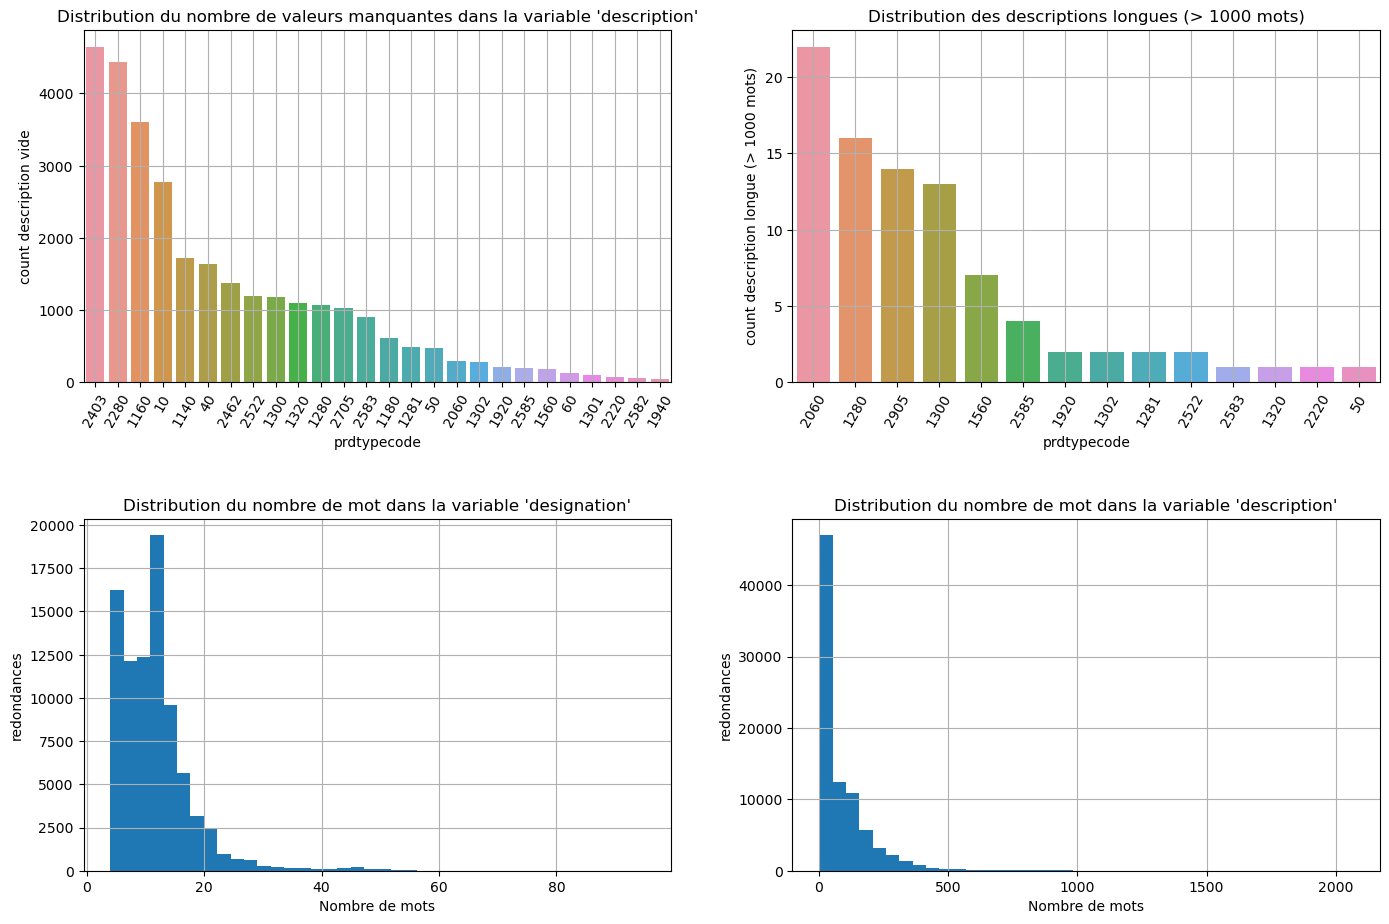

In [12]:
mots_desi = df['designation'].apply(lambda x : str(x))
mots_desi = mots_desi.apply(lambda x : len(x.split(" ")))

mots_desc = df['description'].apply(lambda x : str(x))
mots_desc = mots_desc.apply(lambda x : len(x.split(" ")))

temp = df.merge(target, how='left', on='ID')


plt.figure(figsize=(15, 10))

plt.subplot(221)
sns.countplot(x='prdtypecode', data=temp[temp['description'].isna()], 
              order=temp[temp['description'].isna()].prdtypecode.value_counts().index) 
plt.xticks(rotation=60)
plt.ylabel('count description vide')
plt.title ("Distribution du nombre de valeurs manquantes dans la variable 'description'")
plt.grid()
plt.subplot(222)
sns.countplot(x='prdtypecode', data=temp[mots_desc>1000],
             order=temp[mots_desc>1000].prdtypecode.value_counts().index)
plt.xticks(rotation=60)
plt.ylabel('count description longue (> 1000 mots)')
plt.title ("Distribution des descriptions longues (> 1000 mots)")
plt.grid()

plt.tight_layout(pad=5.0)

plt.subplot(223)
mots_desi.hist(bins= 40)
plt.title ("Distribution du nombre de mot dans la variable 'designation'")
plt.xlabel('Nombre de mots')
plt.ylabel('redondances')
plt.subplot(224)
mots_desc.hist(bins= 40)
plt.title ("Distribution du nombre de mot dans la variable 'description'")
plt.xlabel('Nombre de mots')
plt.ylabel('redondances')



On peut voir sur les deux graphiques ci-dessus que les **designation** et **description** des différents produits varient grandement d'un produit à l'autre. Une **designation** ou une **description** succincte et claire aidera le modèle à apprendre à classer les différentes catégories de produit.  
À l'inverse, si cette **designation** / **description** est trop longue, cela sera trop spécifique pour en tirer quelque-chose. 

## 3.2. Variable cible
Procédons aux même étapes que précédemment :

In [13]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   ID           84916 non-null  int64
 1   prdtypecode  84916 non-null  int64
dtypes: int64(2)
memory usage: 1.3 MB


**Aucune valeur manquante** n'est présente dans ce dataframe.

In [14]:
target.nunique()

ID             84916
prdtypecode       27
dtype: int64

Nous pouvons voir que notre variable cible **prdtypecode** possède **27 modalités** différentes. Observons la distribution de cette variable cible :   

In [15]:
target['prdtypecode'].value_counts()/len(df)

2583    0.120225
1560    0.059741
1300    0.059412
2060    0.058799
2522    0.058752
1280    0.057351
2403    0.056220
2280    0.056055
1920    0.050674
1160    0.046552
1320    0.038167
10      0.036695
2705    0.032514
1140    0.031455
2582    0.030489
40      0.029535
2585    0.029394
1302    0.029335
1281    0.024377
50      0.019796
2462    0.016734
2905    0.010269
60      0.009798
2220    0.009704
1301    0.009504
1940    0.009456
1180    0.008997
Name: prdtypecode, dtype: float64

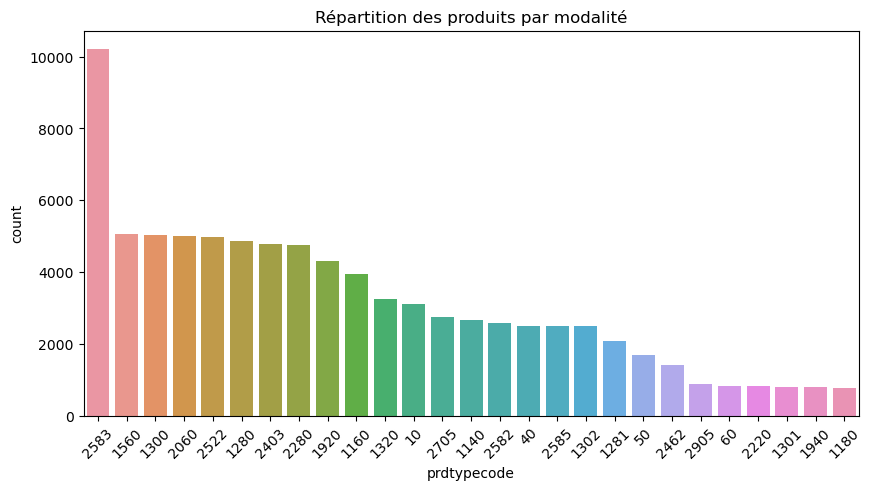

In [16]:
code_bar = pd.DataFrame(target.prdtypecode.value_counts()).reset_index()
code_bar.columns = ['prdtypecode', 'count']
plt.figure(figsize = (10,5))
sns.barplot(data= code_bar, x= 'prdtypecode', y= 'count', order= code_bar.sort_values('count', ascending= False).prdtypecode)
plt.xticks(rotation=45)
plt.title("Répartition des produits par modalité");

On remarque une **grande différence** dans les ordres de grandeur des **proportions de chacunes des modalités**. Cela pourrait poser problème lors de la prédiction des modalités les moins représentées.

## 3.3. Images
Intéressons-nous à présent aux images à notre disposition :

In [17]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_size  84916 non-null  int64 
 1   image       84916 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


Notre dataframe contenant les informations relatives aux images ne **contient pas de donnée manquante**.  <br>


Nous voulons désormais en apprendre plus sur les tailles d'images dont nous disposons. Nous voulons nous assurer que les tailles d'images varient en fonction du code produit. Pour cela, nous devons rajouter les informations de la variable cible. Nous allons donc créer un nouveau dataframe contenant toutes les informations dont nous disposons.

### Fusion des dataframes

Nous construisons maintenant un nouveau dataframe contenant toutes les variables explorées précédemment. Nous mettons également le champs **ID** comme l'**index** de dataframe.

In [18]:
df['image'] = 'image'+'_'+df['imageid'].astype(str)+'_'+'product'+'_'+df['productid'].astype(str)+'.jpg'
df = df.merge(image_df, how='left', on='image')
df = df.merge(target, how='left', on='ID')
df = df.set_index('ID')

df.head()

designation  \
ID                                                      
0   Olivia: Personalisiertes Notizbuch / 150 Seite...   
1   Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   
2   Grand Stylet Ergonomique Bleu Gamepad Nintendo...   
3   Peluche Donald - Europe - Disneyland 2000 (Mar...   
4                                La Guerre Des Tuques   

                                          description   productid     imageid  \
ID                                                                              
0                                                 NaN  3804725264  1263597046   
1                                                 NaN   436067568  1008141237   
2   PILOT STYLE Touch Pen de marque Speedlink est ...   201115110   938777978   
3                                                 NaN    50418756   457047496   
4   Luc a des id&eacute;es de grandeur. Il veut or...   278535884  1077757786   

                                      image  image_size  prdtypecode  
ID                                                                    
0   image_1263597046_product_3804725264.jpg       14010           10  
1    image_1008141237_product_436067568.jpg       14854         2280  
2     image_938777978_product_201115110.jpg        6898           50  
3      image_457047496_product_50418756.jpg       14404         1280  
4    image_1077757786_product_278535884.jpg       20435         2705

<br>  
<br>

Reprenons là où nous nous étions arrêté. Regardons dans un premier temps la **distribution des tailles d'images en fonction des modalités de la variable cible** :

Text(0.5, 1.0, "Distribution des tailles d'image en fonction du code produit")

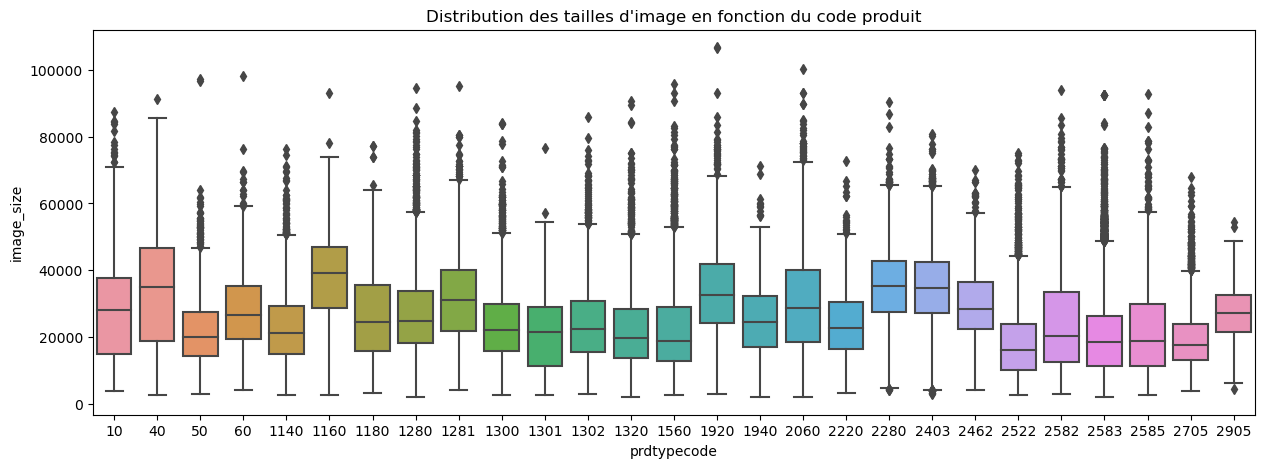

In [19]:
plt.figure(figsize=(15,5))
sns.boxplot(x='prdtypecode',y='image_size',data=df)
plt.title("Distribution des tailles d'image en fonction du code produit")

Ce graphique semble confirmer que la taille d'image varie en fonction du code produit. Cependant nous devons nous en assurer, et pour nous en convaincre nous pouvons utiliser un **test statistique**.  

Le test qui permet de tester la relation entre une variable quantitative et une variable qualitative est celui de l'**analyse de la variance** (**ANOVA**). Celui-ci pose l'hypothèse suivante :
* H0 : les variables sont **indépendantes**

Afin de déterminer si nous rejetons cette hypothèse ou non, nous regarderons la **p_value** du test : si celle-ci est **inférieure à 5%**, nous **rejetterons H0**, les deux variables seront dépendantes.  

Passons au test sur nos variables :

In [20]:
test = statsmodels.formula.api.ols('image_size ~ prdtypecode', data = df).fit()
table = statsmodels.api.stats.anova_lm(test)
table

df        sum_sq       mean_sq          F         PR(>F)
prdtypecode      1.0  1.290581e+11  1.290581e+11  678.58319  5.253152e-149
Residual     84914.0  1.614959e+13  1.901876e+08        NaN            NaN

La p_value est bien inférieure à 5% : nous pouvons **rejeter H0**.  <br>
La taille des images varient bien d'une catégorie produit à l'autre. Cela peut potentiellement s'expliquer par le fait que certaines catégories de produits ont besoin d'une meilleure qualité d'image que d'autres, par exemple pour pouvoir distinguer sur l'image un motif, une spécificité, etc.  

Pour finir sur les images, nous pouvons en **afficher quelques-une** afin de nous donner une idée des produits qui se cachent sous les valeurs de la variable **prdtypecode** :

In [21]:
path = image_path

def show_img(code_prd):
    
    for code in code_prd:
        #print(category)
        f, axarr = plt.subplots(1,5,figsize=(10,5),subplot_kw = dict(xticks=[], yticks=[])) 

        img_list = df[df['prdtypecode'] == code]['image'].head(5).tolist()
        i=0

        for img in img_list:
            plot = plt.imread(path + img);
            #axarr[i].axis('off')
            axarr[i].set_ylabel(code)
            axarr[i].imshow(plot);
            i +=1
            
    return print('Done')

C:\Users\Fenzhengrou\AppData\Local\Temp\ipykernel_16880\1253318857.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(1,5,figsize=(10,5),subplot_kw = dict(xticks=[], yticks=[]))


Done


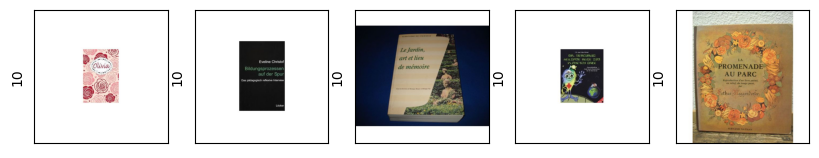

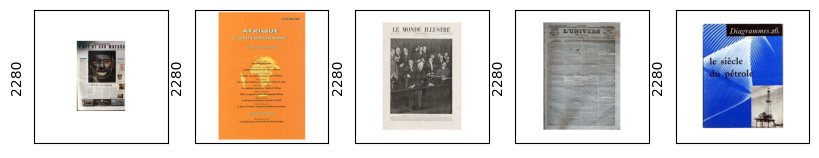

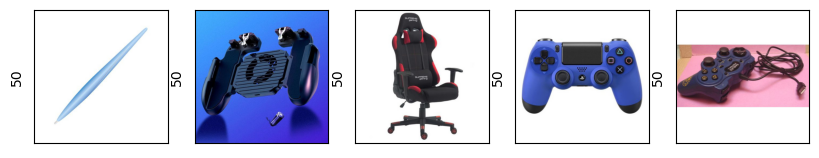

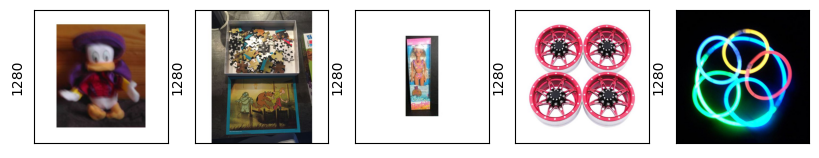

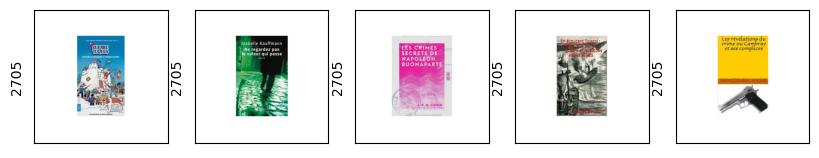

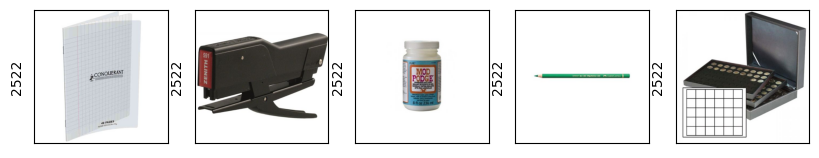

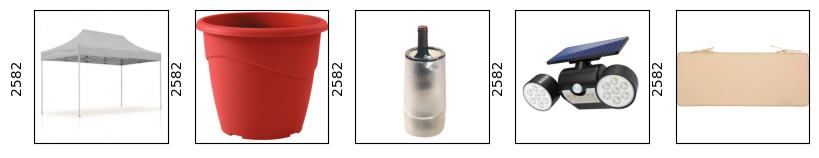

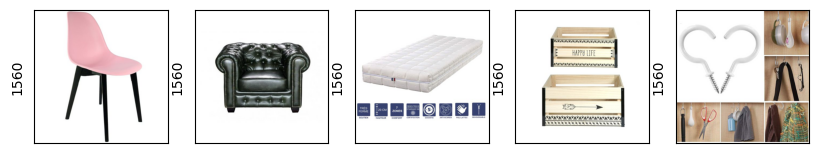

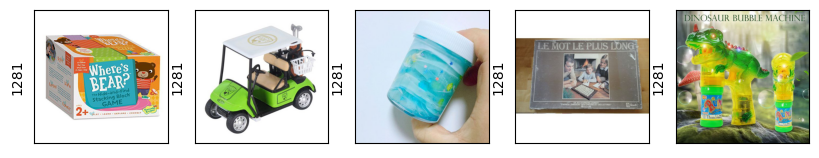

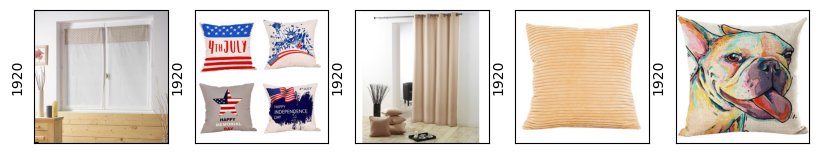

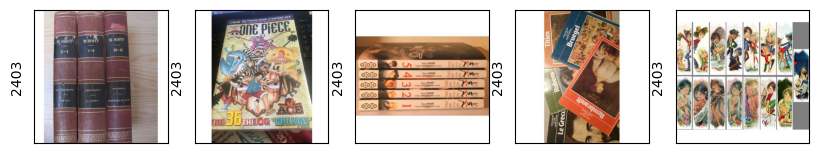

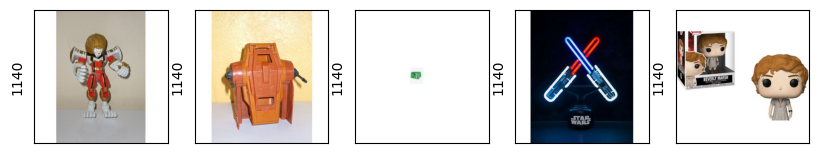

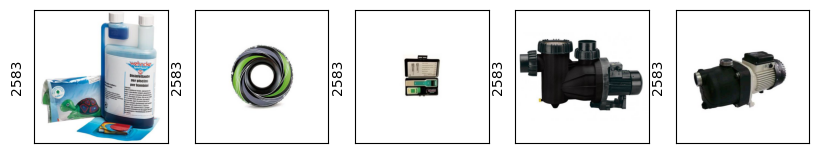

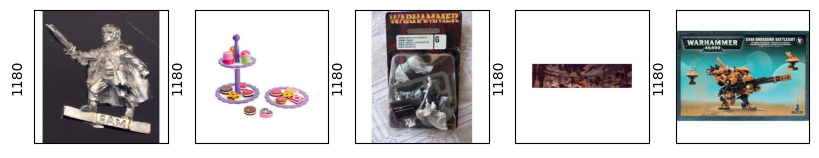

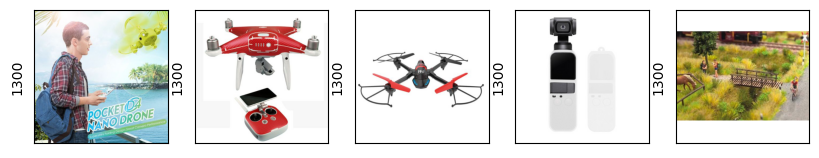

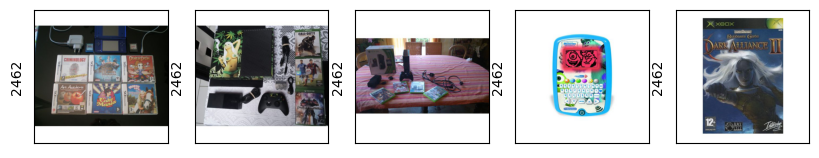

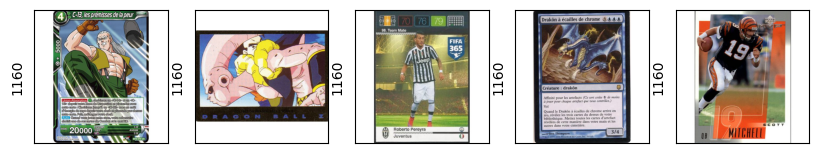

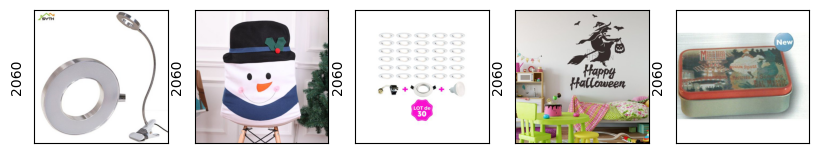

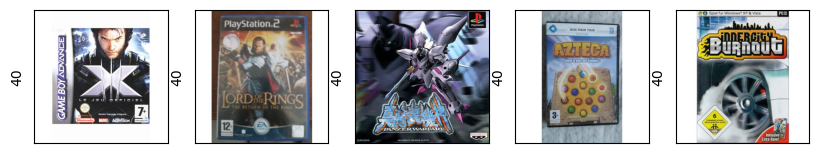

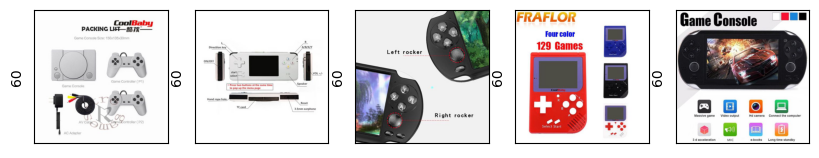

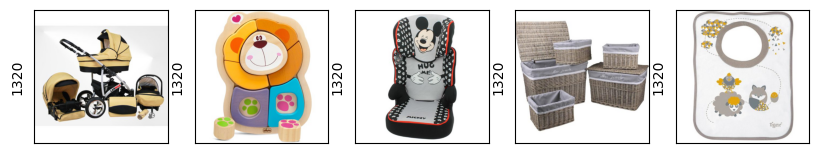

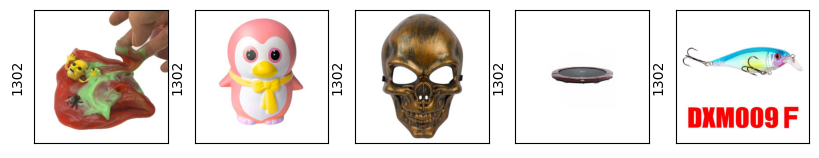

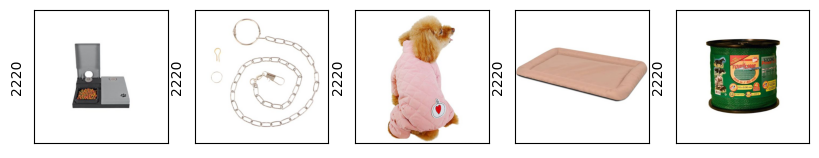

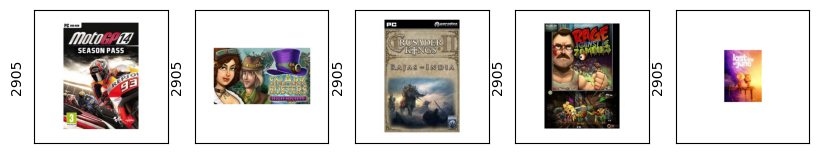

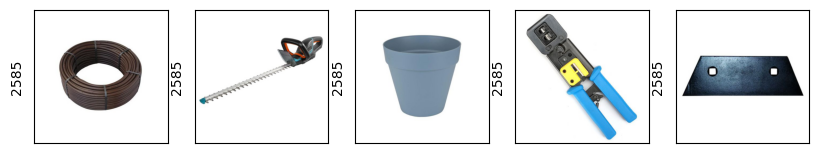

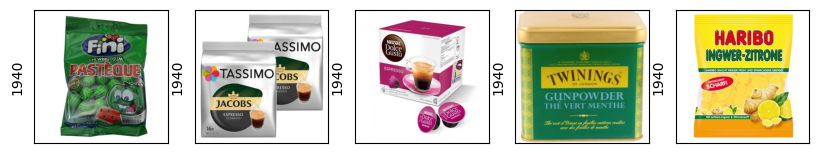

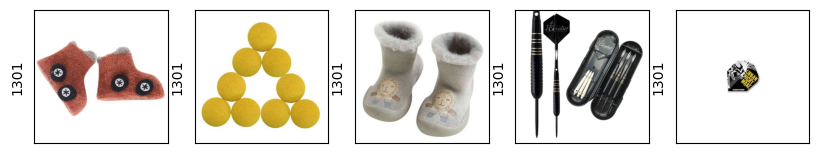

In [22]:
show_img(df.prdtypecode.unique().tolist())

# 4. Pre-processing des données

## 4.1. Etudes des mots  

Comme nous l'avons vu précédemment, les variables **designation** et **description** ont des distributions de tailles déséquilibrées. Nous allons adresser ce problème, mais il peut être intéressant de garder l'information sur les différentes tailles de ces variables.  
Nous allons donc créer ci-dessous deux nouvelles variables contenant ces informations : **designation_nbr_mot** et **description_nrb_mot**.

In [23]:
df['designation_nbr_mot'] = df['designation'].apply(lambda x : len(str(x).split(" ")))
df['description_nrb_mot'] = df['description'].apply(lambda x : len(str(x).split(" ")))
df['description_nrb_mot'].loc[df['description'].isna()] = 0

C:\Users\Fenzhengrou\AppData\Local\Temp\ipykernel_16880\2820764408.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['description_nrb_mot'].loc[df['description'].isna()] = 0


In [24]:
df[['designation_nbr_mot', 'description_nrb_mot']].describe()

designation_nbr_mot  description_nrb_mot
count         84916.000000         84916.000000
mean             11.650926            80.762542
std               6.417576           116.660176
min               4.000000             0.000000
25%               7.000000             0.000000
50%              11.000000            36.000000
75%              14.000000           126.000000
max              95.000000          2068.000000

Text(0.5, 1.0, 'Distribution de nombre de mots en fonction du code produit')

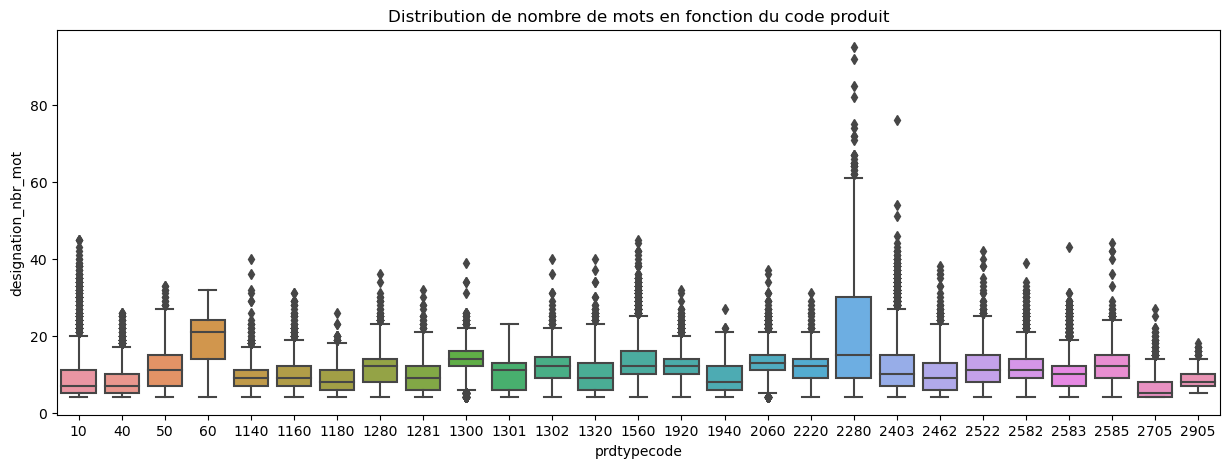

In [25]:
plt.figure(figsize=(15,5))
sns.boxplot(x='prdtypecode',y='designation_nbr_mot',data=df)
plt.title("Distribution de nombre de mots en fonction du code produit")

Text(0.5, 1.0, 'Distribution de nombre de mots en fonction du code produit')

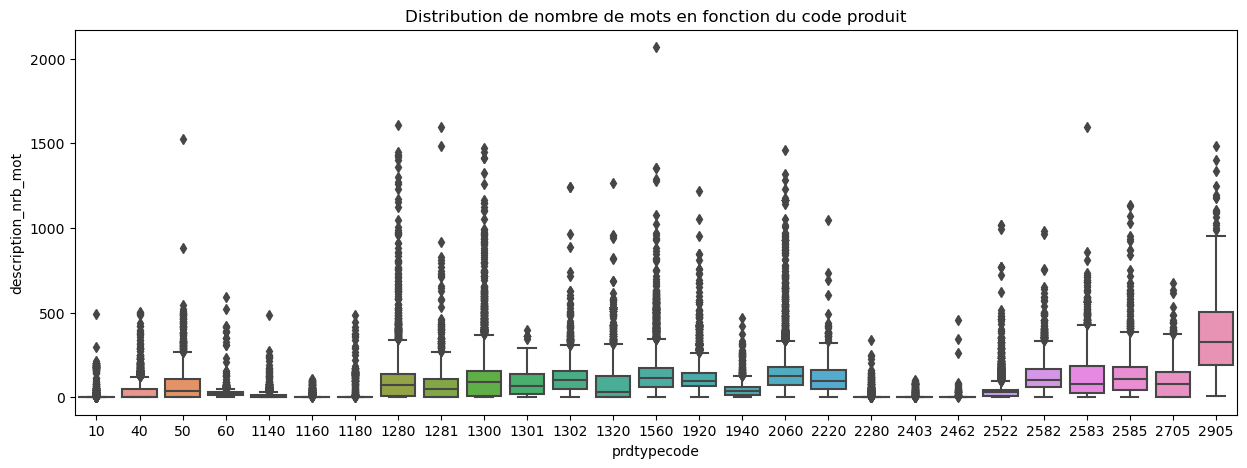

In [26]:
plt.figure(figsize=(15,5))
sns.boxplot(x='prdtypecode',y='description_nrb_mot',data=df)
plt.title("Distribution de nombre de mots en fonction du code produit")

On peut voir sur le boxplot ci-dessus que les tailles de **designation** et **description** semblent variables d'un code produit à un autre. Ces informations peuvent donc potentiellement nous être utiles , mais avant cela nous devons nous assurer que ces tailles sont bien **dépendantes du code produit prdtypecode**. Pour cela, nous allons faire deux test ANOVA, sur **designation** puis sur  **description** :

In [27]:
result = statsmodels.formula.api.ols('designation_nbr_mot ~ prdtypecode', data=df).fit()
table = statsmodels.api.stats.anova_lm(result)

table

df        sum_sq       mean_sq           F        PR(>F)
prdtypecode      1.0  1.478772e+04  14787.716337  360.573783  3.099799e-80
Residual     84914.0  3.482461e+06     41.011624         NaN           NaN

In [28]:
result = statsmodels.formula.api.ols('description_nrb_mot ~ prdtypecode', data=df).fit()
table = statsmodels.api.stats.anova_lm(result)

table

df        sum_sq       mean_sq            F  PR(>F)
prdtypecode      1.0  2.383546e+07  2.383546e+07  1788.233297     0.0
Residual     84914.0  1.131823e+09  1.332906e+04          NaN     NaN

Les **tests ANOVA** sont **concluants** : la p-value est largement inférieure à 5%, on peut rejeter l'hypothèse d'indépendance.

## 4.2. Gestion des valeurs manquantes

Grâce à notre exploration préalable des données, nous savons que des **données** sont **manquantes** uniquement dans la variable **designation**. Nous devons trouver un moyen de faire disparaitre ces données manquantes sans pour autant perdre trop d'information. Pour cela , nous avons retenu **deux méthodes**.

### 4.2.1. Méthode 1

La première solution serait de **répartir équitablement les valeurs manquantes au sein des différentes catégories produits**. Nous ne pouvons pas créer de toutes pièces de nouveaux produits, donc l'idée serait de **supprimer des produits qui n'ont pas de description dans les catégories les plus touchées par les valeurs manquantes** afin que toutes les catégories aient le même nombre de valeurs manquantes, puis d'affecter une **valeur standard** à la place de ces valeurs manquantes. 

Mais le risque serait que certaines catégories produits soient bien trop touchées par les valeurs manquantes et que la perte d'information soit trop importante dans notre jeu de données. Pour vérifier cela, regardons la **distribution des valeurs manquantes par type de produit** :


Text(0, 0.5, 'count description vide')

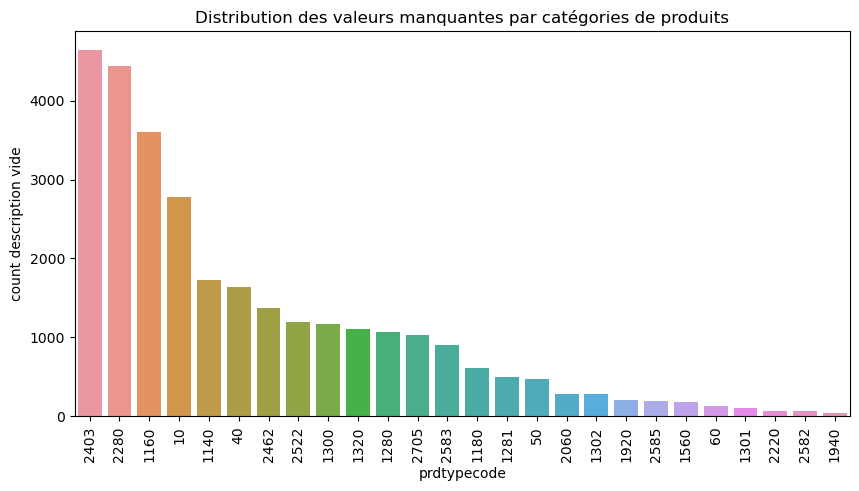

In [29]:
plt.figure(figsize=(10, 5))
sns.countplot(x='prdtypecode', data=df[df['description'].isna()], 
              order=df[df['description'].isna()].prdtypecode.value_counts().index)
plt.title("Distribution des valeurs manquantes par catégories de produits")
plt.xticks(rotation=90)
plt.ylabel('count description vide')

La distribution des valeurs manquantes par catégories de produits est bien trop **déséquilibré**. Cette **première méthode** ne nous **satisfait pas** à la vue de l'importante perte d'information qu'elle entrainerait.

### 4.2.2. Méthode 2

La seconde méthode nous permettant de gérer les valeurs manquantes sans perdre trop d'information est de fusionner les variables **designation** et **description**. Ainsi, il n'y aurait plus de valeurs manquantes car il n'y en a pas dans **designation**, et nous pourrons entrainer des modèles sans trop de perte d'information.

In [30]:
df['designation_description'] = df['designation'] +" "+ df['description']
df['designation_description'].loc[df['description'].isna()] = df['designation']
print("Nombre de valeurs manquantes dans la nouvelle variable :", df['designation_description'].isna().sum())

Nombre de valeurs manquantes dans la nouvelle variable : 0


C:\Users\Fenzhengrou\AppData\Local\Temp\ipykernel_16880\2771489234.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['designation_description'].loc[df['description'].isna()] = df['designation']


La seule perte d'information qui découle de cette solution est le fait de savoir si il y avait une **présence ou non d'une description**. Pour remédier à cela, nous pouvons créer une variable précisant la présence ou non d'une description :

In [31]:
df['avec_description'] = np.where(df['description'].isna(), 0, 1)

## 4.3. Gestion des doublons

Nous avions deux types de doublons : **(a)** les doublons de **designation** pour lesquels **description** était également dédoublé (situation minoritaire), et **(b)** les doublons de **description** pour lesquels plusieurs produits différents pouvaient avoir une même description (situation majoritaire).  
Désormais, nous devrions avoir uniquement des doublons correspondant à la situation **(a)** et donc le nombre de doublons devrait avoir drastiquement chuté :

In [32]:
text_duplic = df['designation_description'][df['designation_description'].duplicated()]
print('textes en doublons :', len(text_duplic))

pd.crosstab(df['prdtypecode'], np.where(df['designation_description'].isin(text_duplic), 1, 0), 
            colnames=['designation_description duplicated']) 

textes en doublons : 1414


designation_description duplicated     0    1
prdtypecode                                  
10                                  3114    2
40                                  2464   44
50                                  1617   64
60                                   805   27
1140                                2669    2
1160                                3951    2
1180                                 764    0
1280                                4823   47
1281                                2016   54
1300                                4970   75
1301                                 628  179
1302                                2300  191
1320                                3207   34
1560                                4959  114
1920                                3932  371
1940                                 801    2
2060                                4751  242
2220                                 820    4
2280                                4760    0
2403                                4755   19
2462                                1396   25
2522                                4920   69
2582                                2467  122
2583                                9599  610
2585                                2434   62
2705                                2756    5
2905                                 872    0

Il nous reste **1414 doublons**, et ceux-ci ne sont **pas répartis équitablement** entre les différentes catégories de produits. Vu qu'ils sont peu nombreux par rapport à la taille de notre jeu de données, la solution la plus simple est de les **supprimer** :

In [33]:
df = df.drop_duplicates(subset='designation_description', keep="first")
text_duplic2 = df['designation_description'][df['designation_description'].duplicated()]
print('textes en doublons :', len(text_duplic2))

textes en doublons : 0


## 4.4. Nettoyage des données textuelles

### 4.4.1. Préparation

Maintenant que nous avons notre variable textuelle propre, nous devons la **préparer** afin qu'elle puisse être utilisée par des modèles de machine learning. Pour cela, nous devons :  
* retirer les balises html présentes dans nos textes;
* transformer les phrases en liste de mots ;
* convertir toutes les lettres en minuscules ;
* supprimer les éléments de ponctuations ;
* gérer les balises, chiffres et autres caractères spéciaux ;
* supprimer les mots liés uniquement à la syntaxe d'une langue.  

Nous faisons le choix de **supprimer** les **chiffres et charactères spéciaux** pour nous concentrer uniquement sur les mots, ainsi que de nous limiter aux **stopwords français et anglais** :

In [34]:
def remove_html_tags(text):
    """Remove html tags from a string"""  
    clean = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(clean, ' ', text)

df['designation_description'] = df['designation_description'].apply(remove_html_tags)

C:\Users\Fenzhengrou\AppData\Local\Temp\ipykernel_16880\4206272771.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['designation_description'] = df['designation_description'].apply(remove_html_tags)


In [35]:
stop_words = set(stopwords.words('french') + stopwords.words('english'))
mots_vides = ["x", "cm", "mm", "h", "g", "peut", "être", 'e',"l'",'x','p','re', 'li','x','b','d','h', 'pla','br','id','al','ra','pla','sine','r','g','v','u','f']
stop_words.update(mots_vides)


def word_split(text):
    """split text into words, remove non alphabetic tokens and stopwords"""
    
    # suppression de la ponctuation
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    text = text.translate(table)
    
    # séparation des textes en listes de mots
    tokens = word_tokenize(text)
    
    # conversion en minuscule
    tokens = [w.lower() for w in tokens]
    
    # restriction aux charactères alphabétiques
    words = [word for word in tokens if word.isalpha()]

    # filtrage des stopwords
    words = [w for w in words if not w in stop_words]
    
    return words

In [36]:
df['designation_description'] = df['designation_description'].apply(word_split)

C:\Users\Fenzhengrou\AppData\Local\Temp\ipykernel_16880\1971935377.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['designation_description'] = df['designation_description'].apply(word_split)


Ci-dessous un **aperçu** de nos **données nettoyées** :

In [37]:
df['designation_description'][:5]

ID
0    [olivia, personalisiertes, notizbuch, seiten, ...
1    [journal, arts, art, marche, salon, art, asiat...
2    [grand, stylet, ergonomique, bleu, gamepad, ni...
3    [peluche, donald, europe, disneyland, marionne...
4    [guerre, tuques, luc, grandeur, veut, organise...
Name: designation_description, dtype: object

Comme nous l'avons fait un peu plus tôt, nous pouvons également récupérer le **nombre de mots** de cette nouvelle variable et réaliser le même test statistique que précédemment :

In [38]:
df['designation_description_nbr_mot'] = df['designation_description'].apply(lambda x : len(x))
df['designation_description_nbr_mot'].describe()

C:\Users\Fenzhengrou\AppData\Local\Temp\ipykernel_16880\2334231799.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['designation_description_nbr_mot'] = df['designation_description'].apply(lambda x : len(x))


count    83502.000000
mean        53.553771
std         66.750665
min          0.000000
25%          7.000000
50%         28.000000
75%         82.000000
max       1081.000000
Name: designation_description_nbr_mot, dtype: float64

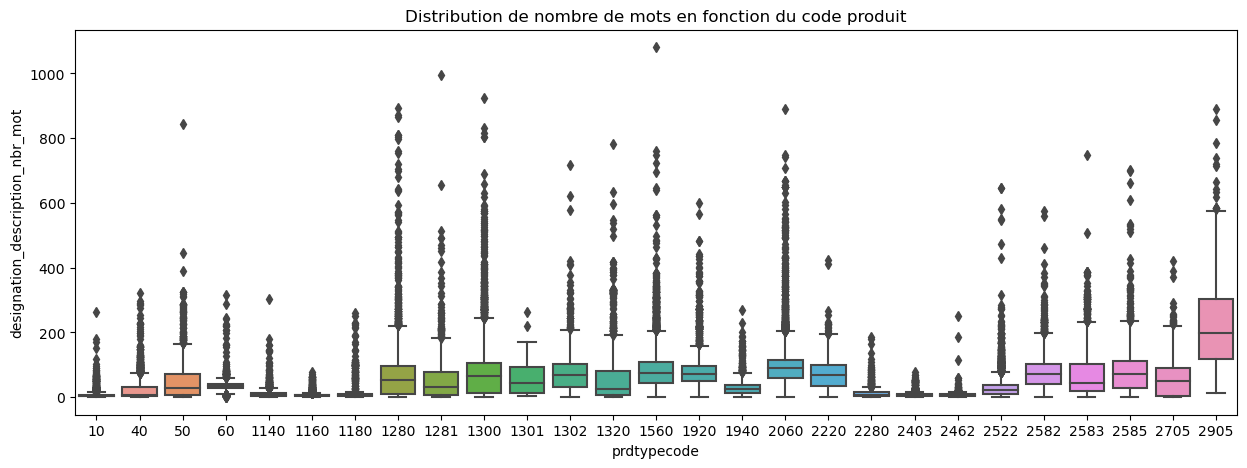

In [39]:
plt.figure(figsize=(15,5))
sns.boxplot(x='prdtypecode',y='designation_description_nbr_mot',data=df)
plt.title("Distribution de nombre de mots en fonction du code produit")
plt.show()

In [40]:
result = statsmodels.formula.api.ols('designation_description_nbr_mot ~ prdtypecode', data=df).fit()
table = statsmodels.api.stats.anova_lm(result)

table

df        sum_sq       mean_sq            F         PR(>F)
prdtypecode      1.0  5.793003e+06  5.793003e+06  1320.695438  6.362276e-287
Residual     83500.0  3.662583e+08  4.386327e+03          NaN            NaN

### 4.4.2. Traitements des textes longs

Une autre problématique qui nous reste est celle de la taille en nombre de mots pour la variable **designation_description** : il nous faut fixer un **seuil** au-delà duquel nous n'acceptons plus ces descriptions que nous jugerons **trop différentes** des autres par leurs tailles. Pour fixer ce seuil, nous pouvons regarder la **distribution du nombre de mots par catégories de produits** :

In [41]:
df.groupby(["prdtypecode"])['designation_description_nbr_mot'].describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95])

count        mean         std   min    25%    50%    75%    90%  \
prdtypecode                                                                     
10           3114.0    7.966924   11.900670   1.0    3.0    5.0    8.0   14.0   
40           2484.0   21.554750   34.725838   1.0    4.0    6.0   32.0   65.0   
50           1645.0   49.629179   60.561243   1.0    8.0   29.0   71.0  112.0   
60            817.0   38.123623   32.009927   2.0   28.0   35.0   41.0   63.4   
1140         2670.0   12.037828   14.431154   1.0    5.0    8.0   14.0   23.0   
1160         3952.0    7.617915    6.312599   1.0    5.0    6.0    8.0   12.0   
1180          764.0   18.836387   36.719484   2.0    4.0    6.0    9.0   63.4   
1280         4848.0   68.008870   79.707251   1.0   11.0   54.0   95.0  138.3   
1281         2040.0   51.038235   62.029811   1.0    7.0   32.0   77.0  114.0   
1300         5006.0   81.231522   86.683090   2.0   14.0   66.0  106.0  183.0   
1301          693.0   51.926407   41.165626   3.0   14.0   44.0   92.0  105.0   
1302         2375.0   75.168842   57.872814   2.0   33.0   70.0  104.0  141.0   
1320         3223.0   51.481539   68.964057   2.0    6.0   24.0   80.0  119.0   
1560         5008.0   89.498403   71.299894   2.0   44.0   76.0  109.0  170.3   
1920         4085.0   77.362301   52.487496   2.0   51.0   72.0   96.0  125.0   
1940          802.0   34.885287   34.752944   2.0   14.0   26.0   39.0   78.9   
2060         4859.0  101.794608   81.451118   1.0   58.0   89.0  116.0  205.0   
2220          822.0   71.738443   49.378411   2.0   35.0   69.0   99.0  123.9   
2280         4760.0   10.982773   10.274654   0.0    5.0    8.0   16.0   21.0   
2403         4763.0    7.590594    6.478078   0.0    4.0    6.0    9.0   15.0   
2462         1407.0    7.339019    9.980111   1.0    4.0    6.0    9.0   12.0   
2522         4949.0   31.333603   37.282975   1.0   10.0   23.0   37.0   61.0   
2582         2508.0   80.328947   55.233643   2.0   41.0   73.0  104.0  143.3   
2583         9814.0   64.650499   56.868266   1.0   18.0   45.0  104.0  142.0   
2585         2463.0   81.977263   70.277102   2.0   29.0   72.0  111.0  175.0   
2705         2759.0   54.900326   52.788396   0.0    4.0   50.0   90.0  122.0   
2905          872.0  222.720183  138.221406  14.0  118.0  198.5  303.0  406.8   

                95%     max  
prdtypecode                  
10            21.00   263.0  
40            90.00   323.0  
50           166.00   843.0  
60            77.00   316.0  
1140          30.00   304.0  
1160          18.00    77.0  
1180          99.00   261.0  
1280         197.00   892.0  
1281         144.00   994.0  
1300         242.00   923.0  
1301         113.40   263.0  
1302         160.00   716.0  
1320         168.90   783.0  
1560         225.00  1081.0  
1920         154.00   601.0  
1940         104.85   270.0  
2060         224.00   890.0  
2220         148.65   423.0  
2280          23.00   186.0  
2403          20.00    79.0  
2462          14.00   252.0  
2522          94.60   647.0  
2582         187.00   575.0  
2583         167.00   747.0  
2585         191.90   702.0  
2705         147.00   420.0  
2905         477.00   889.0

On peux voir que pour certaine catégories, le **nombre de mot explose entre les valeurs maximales et 90%** des valeurs restantes. Nous décidons donc de fixer notre seuil à **90%**. Vérifions l'impact que cela a sur notre jeu de données :

In [42]:
df = df[df.groupby(["prdtypecode"])['designation_description_nbr_mot'].apply(lambda x : x < x.quantile(q=0.9))]
df['designation_description_nbr_mot'].describe()

count    74854.000000
mean        41.670732
std         44.097373
min          0.000000
25%          6.000000
50%         22.000000
75%         71.000000
max        405.000000
Name: designation_description_nbr_mot, dtype: float64

Nous avons exclu un nombre raisonnable de données, et la taille maximale de **designation_description** a drastiquement chutée. Vérifions maintenant la présence de valeurs extrême :

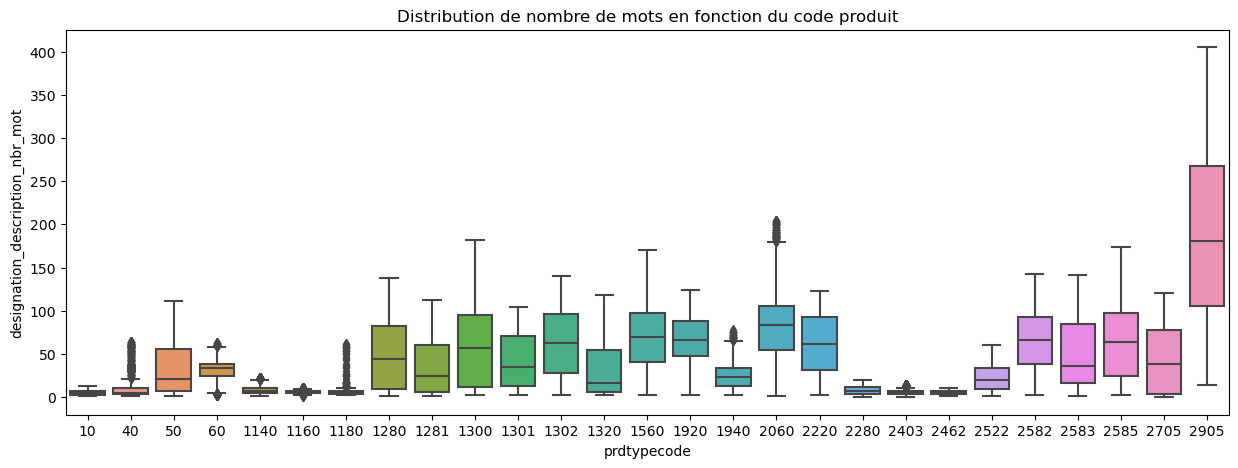

In [43]:
plt.figure(figsize=(15,5))
sns.boxplot(x='prdtypecode',y='designation_description_nbr_mot',data=df)
plt.title("Distribution de nombre de mots en fonction du code produit")
plt.show()

Certaine catégories ont encore quelques valeurs extrême, mais ce **seuil nous satisfait**. En effet, si nous continuons de l'abaisser, nous exclurons de plus en plus de données et risquerions une perte trop importante d'informations.

### 4.4.3. Catégorisation des codes types de produits

Une dernière problématique serait le nombre de catégories de produits que nous avons. Si nous gardons un nombre élevé de catégories, nos modèles risquent de **moins bien prédire les catégories les moins représentées**.  

Pour remédier à cela, nous pouvons créer des **super-catégories** de produits comme suit :

In [44]:
dict_cat = {'Livres':[10, 2280, 2403, 2522, 2705],
            'Jeux':[40, 50, 60, 2462, 2905],
            'Jouets & figurines':[1140, 1160, 1180, 1280, 1281, 1300, 1302],
            'Meubles':[1560, 2582],
            'Equipements divers':[1320, 2220, 2583, 2585],
            'Deco':[1920, 2060],
            'Autres':[1301, 1940]}

for key, value in dict_cat.items():
    df.loc[df['prdtypecode'].isin(value), 'prdcat'] = key

C:\Users\Fenzhengrou\AppData\Local\Temp\ipykernel_16880\3191157288.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['prdtypecode'].isin(value), 'prdcat'] = key


Nous pouvons regarder la distribution des produits par super-catégories :

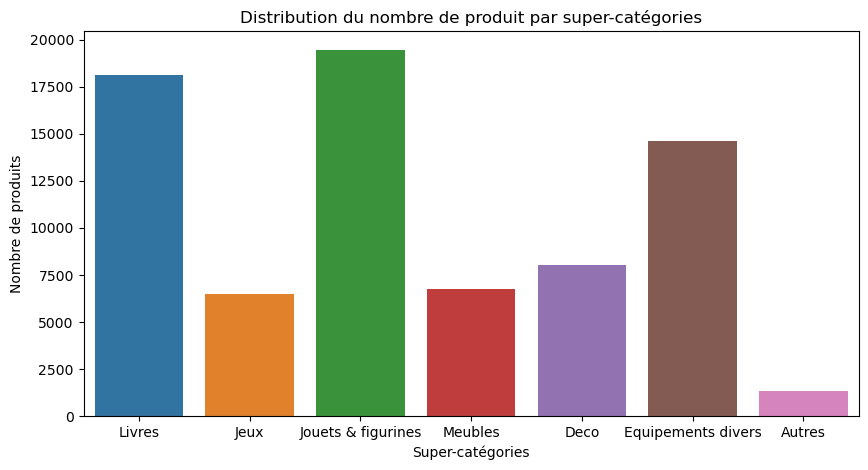

In [45]:
plt.figure(figsize=(10,5))
sns.countplot(x=df.prdcat, data=df)
plt.title("Distribution du nombre de produit par super-catégories")
plt.xlabel("Super-catégories")
plt.ylabel("Nombre de produits")
plt.show()

Enfin, nous pouvons regarder les **mots les plus présents** par super-catégories :

Il y a 2130585 mots dans la categorie Livres


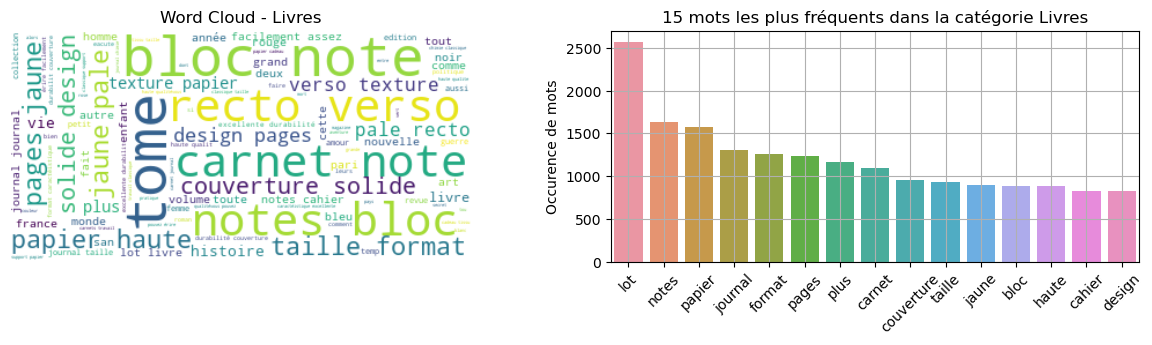

Il y a 1914938 mots dans la categorie Jeux


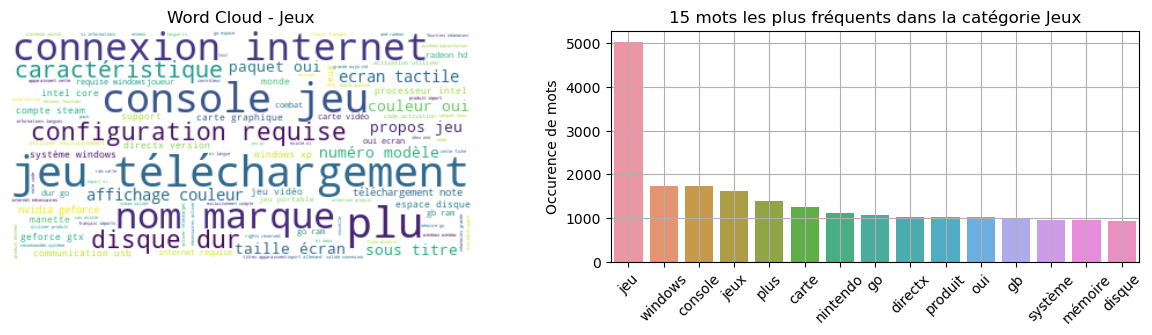

Il y a 5452268 mots dans la categorie Jouets & figurines


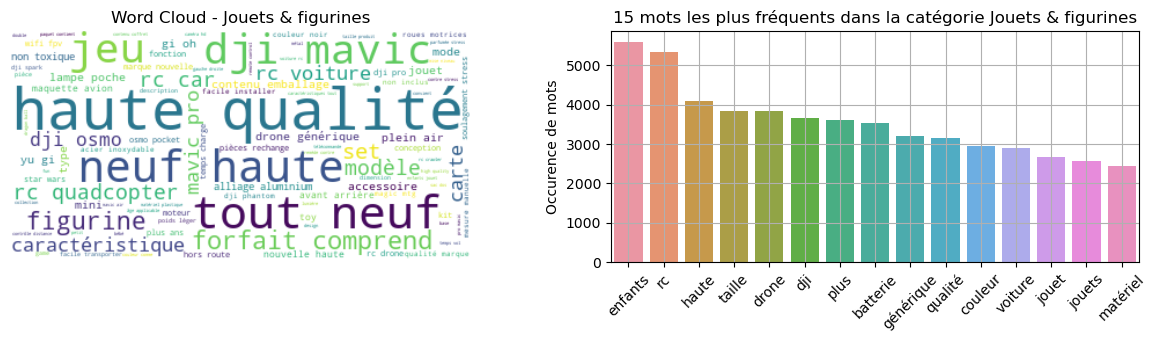

Il y a 3653133 mots dans la categorie Meubles


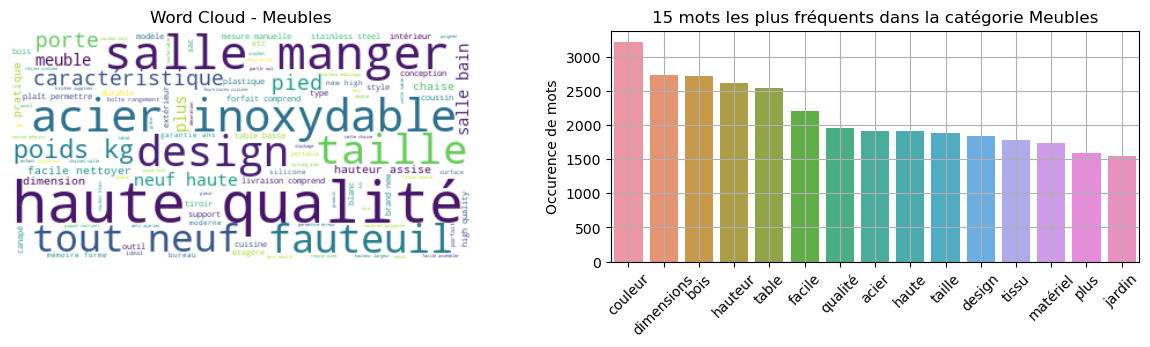

Il y a 5659071 mots dans la categorie Equipements divers


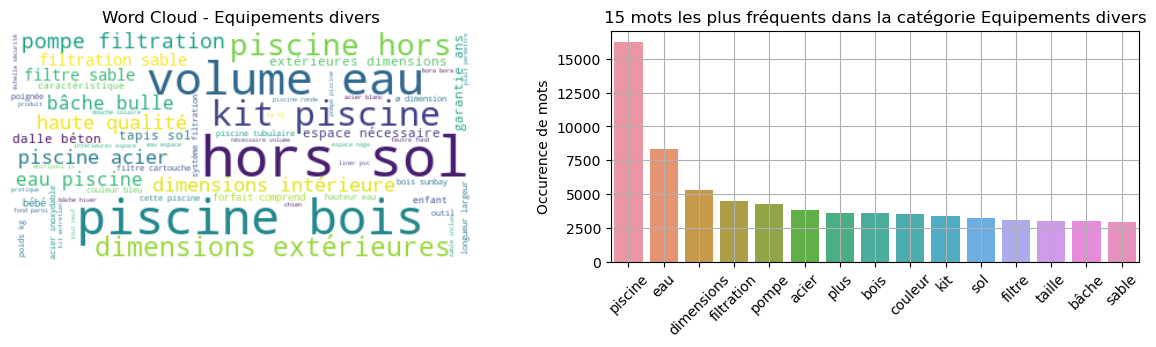

Il y a 4519974 mots dans la categorie Deco


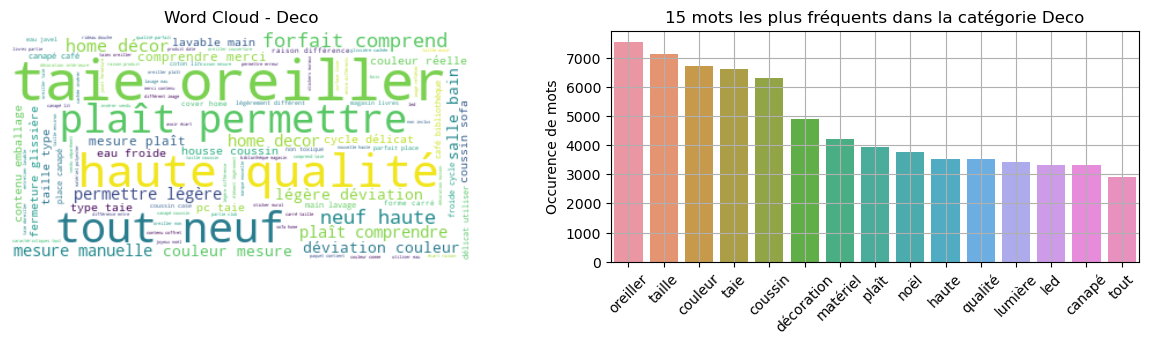

Il y a 335834 mots dans la categorie Autres


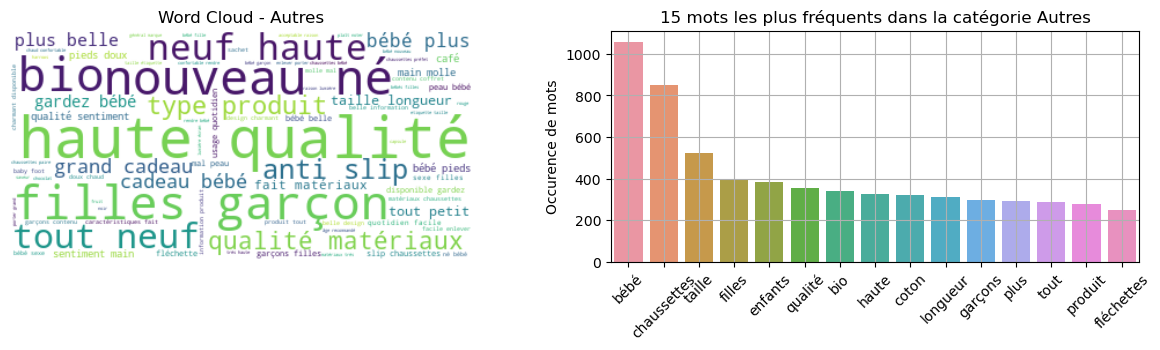

In [46]:
for categorie in dict_cat.keys():
    text = " ".join(w for text in df[df.prdcat == categorie]['designation_description'] for w in text)
    print ( ("Il y a {} mots dans la categorie "+categorie).format(len(text)))

    word_count = Counter(text.split(" "))
    mots = [m[0] for m in word_count.most_common(15)]
    freq = [m[1] for m in word_count.most_common(15)]

    wordcloud = WordCloud(max_font_size=50, max_words=100, stopwords=stop_words, background_color="white").generate(text)

    plt.figure(figsize=(15, 3))
    plt.subplot(121)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title('Word Cloud - '+categorie)
    plt.subplot(122)
    sns.barplot(x=mots, y=freq)
    plt.title('15 mots les plus fréquents dans la catégorie '+categorie)
    plt.xticks(rotation=45)
    plt.ylabel('Occurence de mots')
    plt.grid()
    plt.show()

## 4.5. Choix des variables pertinentes

Ci-dessous notre dataset, nettoyé et réduit aux variables nécéssaires pour la suite du projet :

In [47]:
df = df.drop(['designation', 'description', 'productid', 'imageid', 'designation_nbr_mot', 'description_nrb_mot'], axis= 1)
df.head()

image  image_size  prdtypecode  \
ID                                                                     
0   image_1263597046_product_3804725264.jpg       14010           10   
1    image_1008141237_product_436067568.jpg       14854         2280   
2     image_938777978_product_201115110.jpg        6898           50   
3      image_457047496_product_50418756.jpg       14404         1280   
4    image_1077757786_product_278535884.jpg       20435         2705   

                              designation_description  avec_description  \
ID                                                                        
0   [olivia, personalisiertes, notizbuch, seiten, ...                 0   
1   [journal, arts, art, marche, salon, art, asiat...                 0   
2   [grand, stylet, ergonomique, bleu, gamepad, ni...                 1   
3   [peluche, donald, europe, disneyland, marionne...                 0   
4   [guerre, tuques, luc, grandeur, veut, organise...                 1   

    designation_description_nbr_mot              prdcat  
ID                                                       
0                                 9              Livres  
1                                20              Livres  
2                                80                Jeux  
3                                 6  Jouets & figurines  
4                                18              Livres

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74854 entries, 0 to 84915
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   image                            74854 non-null  object
 1   image_size                       74854 non-null  int64 
 2   prdtypecode                      74854 non-null  int64 
 3   designation_description          74854 non-null  object
 4   avec_description                 74854 non-null  int32 
 5   designation_description_nbr_mot  74854 non-null  int64 
 6   prdcat                           74854 non-null  object
dtypes: int32(1), int64(3), object(3)
memory usage: 4.3+ MB


In [49]:
df.describe()

image_size   prdtypecode  avec_description  \
count   74854.000000  74854.000000      74854.000000   
mean    26288.200470   1769.118190          0.619513   
std     13780.700043    789.806596          0.485510   
min      2061.000000     10.000000          0.000000   
25%     15458.000000   1281.000000          0.000000   
50%     24244.500000   1920.000000          1.000000   
75%     35230.000000   2522.000000          1.000000   
max    106720.000000   2905.000000          1.000000   

       designation_description_nbr_mot  
count                     74854.000000  
mean                         41.670732  
std                          44.097373  
min                           0.000000  
25%                           6.000000  
50%                          22.000000  
75%                          71.000000  
max                         405.000000